In [2]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix


In [3]:
##For this churn problem - the data is being loaded from https://www.kaggle.com/blastchar/telco-customer-churn

file = '../WA_Fn-UseC_-Telco-Customer-Churn.csv'

churn_data = pd.read_csv(file)

In [4]:
churn_data.columns = [col.title() for col in churn_data.columns]
churn_data.head()

,Customerid,Gender,Seniorcitizen,Partner,Dependents,Tenure,Phoneservice,Multiplelines,Internetservice,Onlinesecurity,...,Deviceprotection,Techsupport,Streamingtv,Streamingmovies,Contract,Paperlessbilling,Paymentmethod,Monthlycharges,Totalcharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
churn_data.dtypes

Customerid           object
Gender               object
Seniorcitizen         int64
Partner              object
Dependents           object
Tenure                int64
Phoneservice         object
Multiplelines        object
Internetservice      object
Onlinesecurity       object
Onlinebackup         object
Deviceprotection     object
Techsupport          object
Streamingtv          object
Streamingmovies      object
Contract             object
Paperlessbilling     object
Paymentmethod        object
Monthlycharges      float64
Totalcharges         object
Churn                object
dtype: object

Our baseline is going to be randomly assigning a class - 0/1 for No churn/Churn respectively

I am selecting three models here - linear regression for its class probability estimations, knn as it based on distances and a tree based random forest model for its information gain with features. We can later make ensemble models combining them.

In [5]:
#reengineering some features to reduce the distance issues with some classification models.
churn_data['Tenure_in_yrs'] = churn_data['Tenure']//12
churn_data['Monthlycharges_100s'] = round(churn_data['Monthlycharges']/100,2)

#convert total charges to float and converting it to 1000's
churn_data['Totalcharges'] = pd.to_numeric(churn_data['Totalcharges'], errors='coerce').fillna(0)
churn_data['Totalcharges_1000s'] = round(churn_data['Totalcharges']/1000, 2)

#dropping the original columns and also customer id
churn_data.drop(columns = ['Tenure','Monthlycharges','Totalcharges','Customerid'],inplace = True)

#replace 'No Internet Service' and 'No Phone Service'  as No
churn_data = churn_data.replace({'No phone service':'No', 'No internet service':'No'})

In [6]:
def transform_categorical_data(df, cols, drop_first=True, convert_ascat = True):
    """
    Transform categorical data in the columns into dummy data using pandas.
    ----------
    df : Dataframe 
    cols : categorical columns to be converted into dummy data
    drop_orgnl : Boolean, if set to True drops the original column.
    drop_first : Boolean if True drops one of the dummy column
    convert_ascat : convert columns into categorical.
    
    Return
    -------
    Dataframe with the original frame concatenated with dummy data
    """
    from sklearn.preprocessing import LabelEncoder
    
    if convert_ascat == True:
        df[cols] = df[cols].astype('category')
    binary_cols = [c for c in cols if df[c].nunique() ==2]
    multi_cols = [ c for c in cols if c not in binary_cols]
    
    
    le = LabelEncoder()
    for i in binary_cols:
        df[i] = le.fit_transform(df[i])
    
    df = pd.get_dummies(data = df,columns = multi_cols, drop_first=drop_first)
    
    return df

In [7]:
#taking all the columns except for the customer id
cat_cols = [col for col in churn_data.columns if (churn_data[col].dtype.name in ['object','category'])]

churn_data = transform_categorical_data(churn_data, cat_cols)
churn_data.head()

,Gender,Seniorcitizen,Partner,Dependents,Phoneservice,Multiplelines,Onlinesecurity,Onlinebackup,Deviceprotection,Techsupport,...,Tenure_in_yrs,Monthlycharges_100s,Totalcharges_1000s,Internetservice_Fiber optic,Internetservice_No,Contract_One year,Contract_Two year,Paymentmethod_Credit card (automatic),Paymentmethod_Electronic check,Paymentmethod_Mailed check
0,0,0,1,0,0,0,0,1,0,0,...,0,0.30,0.03,0,0,0,0,0,1,0
1,1,0,0,0,1,0,1,0,1,0,...,2,0.57,1.89,0,0,1,0,0,0,1
2,1,0,0,0,1,0,1,1,0,0,...,0,0.54,0.11,0,0,0,0,0,0,1
3,1,0,0,0,0,0,1,0,1,1,...,3,0.42,1.84,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0.71,0.15,1,0,0,0,0,1,0


In [8]:
churn_data.columns

Index(['Gender', 'Seniorcitizen', 'Partner', 'Dependents', 'Phoneservice',
       'Multiplelines', 'Onlinesecurity', 'Onlinebackup', 'Deviceprotection',
       'Techsupport', 'Streamingtv', 'Streamingmovies', 'Paperlessbilling',
       'Churn', 'Tenure_in_yrs', 'Monthlycharges_100s', 'Totalcharges_1000s',
       'Internetservice_Fiber optic', 'Internetservice_No',
       'Contract_One year', 'Contract_Two year',
       'Paymentmethod_Credit card (automatic)',
       'Paymentmethod_Electronic check', 'Paymentmethod_Mailed check'],
      dtype='object')

In [8]:
#creating a new feature family that captures if a customer has a partner or dependents (children or parents)
churn_data['Family'] = np.where((churn_data['Partner'] == 1) |(churn_data['Dependents'] == 1),1,0)
churn_data.drop(columns=['Partner','Dependents'],inplace=True)

In [9]:
#removing Total charges also as its highly related to monthly charges and tenure.
X, Y = churn_data.drop(columns=['Churn','Totalcharges_1000s']), churn_data.Churn

In [11]:
#creating a baseline predictor that randomly assigns a customer as churn or no churn
def baseline_pred(X, y_true):
    from numpy.random import rand, randint
    y_pred = [randint(0,2) for i in range(X.shape[0])]
   
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = round(tp/X.shape[0],3)
    print('baseline accuracy is {}'.format(accuracy))    

baseline_pred(X, Y)

baseline accuracy is 0.132


In [10]:
#defining the metrics we want to use to compare for each model
def classification_metrics(y_true, y_pred, model, y_prob, ret_results = True, print_res = True):
    """
    Calculates different classification metrics for the model, and prints out the results
    ----------
    y_true : actual output values 
    y_pred : predicted values based on the model
    model : Classification model with already training data fitted on the model
    ret_results : To return different metrics as a dictionary
    print_res : prints out the metrics as well as roc curve.
    
    Return
    -------
    Returns a dictionary with different metrics if ret_results is set to True
    """
    import matplotlib.pyplot as plt
    
    #balanced accuracy score
    from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score, roc_curve, auc
    acc = round(accuracy_score(y_true, y_pred),3)
    bal_acc = round(balanced_accuracy_score(y_true, y_pred),3)
    #sensitivity and specificity - identifiying churning customers more important than stable customers
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = round(tp/(tp+fn), 3)
    specificity = round(tn/(tn+fp), 3)
    
    #auc score
    fpr, tpr, thresholds = roc_curve(y_true, y_prob[:,1])
    auc_score = round(auc(fpr, tpr), 3)
    res_dict = {'Accuracy':acc, 'Balanced acc':bal_acc, 'sensitivity': sensitivity, 
                'specificity':specificity, 'auc':auc_score}
    
    if print_res == True:
        print(model)
        print(res_dict)
        
        plt.grid()
        plt.plot(fpr,tpr)
        plt.fill_between(fpr, tpr, color = 'silver')
        plt.annotate('Area under Curve {}'.format(auc_score), (0,0.9), fontsize = 10)
        plt.title('ROC Curve')
        plt.show()
    
    if ret_results == True:
        return res_dict


In [11]:
# need to generalize this function with any model and its additional parameters


def model_CVsplit_metrics(X, Y, model, size = 0.4, random_st = 16):
    """
    Fits the classification model with a train test split and calculates and displays the metrics
    ----------
    X : input data set 
    Y : output labels 
    model : Classification model with parameters tuned.
    size : Size of the test for the train_test_split
    random_st : random state value
    
    Return
    -------
    Returns the model with fitted data
    """
    from sklearn.model_selection import train_test_split
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y , test_size=size, random_state = random_st)
    
    model = model.fit(X_train,y_train)
    
    test_score = model.score(X_test, y_test)
    train_score = model.score(X_train, y_train)
       
    print('test score {0:.3g}'.format(test_score))
    print('training score {0:.3g}'.format(train_score))
    
    y_hat = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    classification_metrics(y_true = y_test, y_pred=y_hat, model=model, y_prob=y_proba, ret_results= False)
    return model

test score 0.797
training score 0.805
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
{'Accuracy': 0.797, 'Balanced acc': 0.717, 'sensitivity': 0.548, 'specificity': 0.885, 'auc': 0.84}


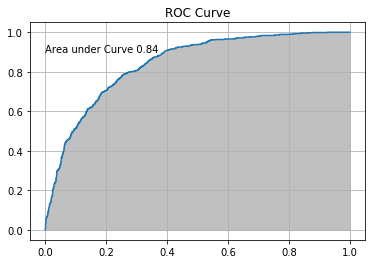

In [12]:
#applying logistic regression
logit = LogisticRegression(solver='liblinear')
logit = model_CVsplit_metrics(X, Y, model= logit)

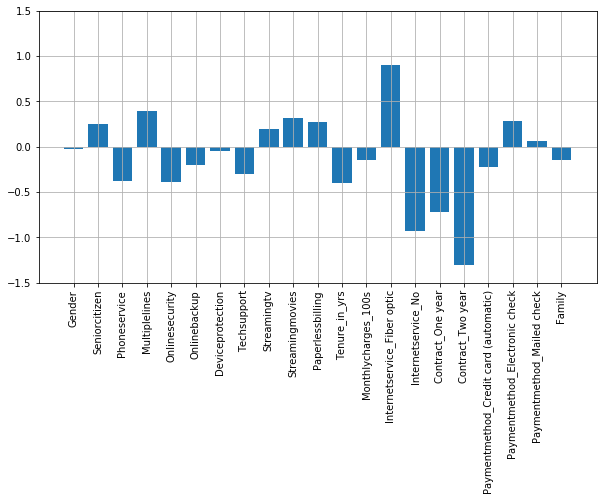

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(x = X.columns, height=logit.coef_[0])
plt.xticks(rotation=90)
plt.ylim(-1.5,1.5)
plt.grid()
plt.show()

test score 0.755
training score 0.972
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
{'Accuracy': 0.755, 'Balanced acc': 0.671, 'sensitivity': 0.497, 'specificity': 0.846, 'auc': 0.747}


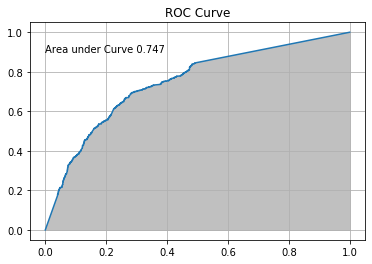

In [19]:
knn_model = KNeighborsClassifier(weights='distance')
knn_model = model_CVsplit_metrics(X,Y, knn_model)

test score 0.775
training score 0.973
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'Accuracy': 0.775, 'Balanced acc': 0.682, 'sensitivity': 0.488, 'specificity': 0.876, 'auc': 0.798}


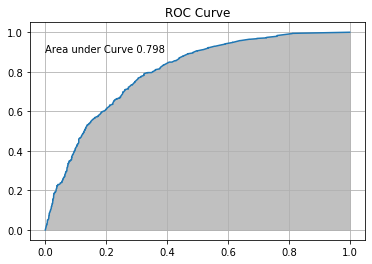

In [17]:
rnd_forest = RandomForestClassifier(n_estimators=100)
rnd_forest = model_CVsplit_metrics(X,Y,rnd_forest)

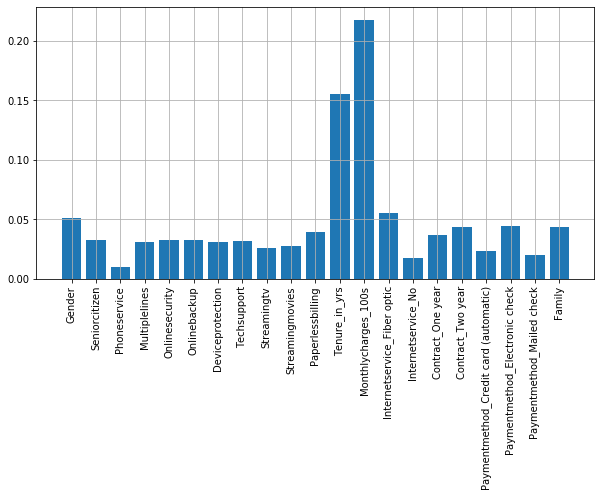

In [15]:
plt.figure(figsize=(10,5))
plt.bar(x = X.columns, height=rnd_forest.feature_importances_)
plt.xticks(rotation=90)
plt.grid()
plt.show()


In [20]:
#lets try voting classifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

vclf = VotingClassifier(estimators=[('lr',logit),('knn',knn_model),('rf',rnd_forest)], voting='hard')
for clf, label in zip([logit, knn_model, rnd_forest, vclf], ['Logistic reg','KNN classification','Random forest','Voting ensemble']):
    scores = cross_val_score(clf, X, Y, scoring ='accuracy', cv=5)
    print('Accuracy : %0.3f (+/- %0.2f) [%s]'%(scores.mean(), scores.std(), label))


Accuracy : 0.798 (+/- 0.01) [Logistic reg]
Accuracy : 0.760 (+/- 0.01) [KNN classification]
Accuracy : 0.774 (+/- 0.01) [Random forest]
Accuracy : 0.777 (+/- 0.02) [Voting ensemble]


Balanced accuracy is around 10% lesser than actual accuracy. This could be an indication of unbalanced classes. Can try to do some sampling techniques to see if it improves the prediction. 

Logistic regression, performs better. The accuracy is better than any of the models, and even its performence (auc)is better than other models. 

In [30]:
from sklearn.model_selection import GridSearchCV
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)    

parameters = {'penalty':('l2','l1'), 'C' : (0.01, 0.1, 1, 10, 50, 100), 'max_iter' : (75, 100, 150, 200, 400)}
logit_tune = LogisticRegression()

gridclf = GridSearchCV(logit_tune, parameters, scoring = ['accuracy', 'roc_auc'], refit = 'accuracy', cv = 5)
gridclf.fit(X,Y)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': (0.01, 0.1, 1, 10, 50, 100),
                         'max_iter': (75, 100, 150, 200, 400),
                         'penalty': ('l2', 'l1')},
             pre_dispatch='2*n_jobs', refit='accuracy',
             return_train_score=False, scoring=['accuracy', 'roc_auc'],
             verbose=0)

In [31]:
gridclf.best_params_

{'C': 0.1, 'max_iter': 75, 'penalty': 'l1'}

In [28]:
gridclf.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
gridclf.best_score_

0.7986653414738037

In [33]:
gridclf.scorer_

{'accuracy': make_scorer(accuracy_score),
 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)}

In [45]:
grid_scores = cross_val_score(gridclf.best_estimator_, X, Y, scoring = 'accuracy', cv = 5)
print('Accuracy = %0.3f(+/- %0.2f)'%(grid_scores.mean(), grid_scores.std()))

Accuracy = 0.799(+/- 0.01)


In [22]:
#hypertuning random forest based on no of estimators
#from IPython.display import display
# no of trees can change the overall performance of the model. So lets use auc score
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, Y , test_size=0.4, random_state = 42)
estimators_list = [1,2,3,4,5,10,15,20,30,50,70,80,100,120, 140,150,200, 220, 240, 250 ]
auc_score = []

for estimator in estimators_list:
    model = RandomForestClassifier(n_estimators=estimator, random_state=42)
    model.fit(X_train,y_train)
    auc_score.append(roc_auc_score(y_test, model.predict(X_test)))
    
print(DataFrame({'num_estimator':estimators_list, 'auc':auc_score}))    

    num_estimator       auc
0               1  0.634310
1               2  0.617820
2               3  0.663058
3               4  0.656701
4               5  0.671954
5              10  0.664654
6              15  0.671906
7              20  0.672976
8              30  0.668614
9              50  0.681953
10             70  0.687109
11             80  0.691839
12            100  0.691655
13            120  0.688191
14            140  0.688617
15            150  0.689100
16            200  0.686131
17            220  0.684795
18            240  0.686188
19            250  0.683034


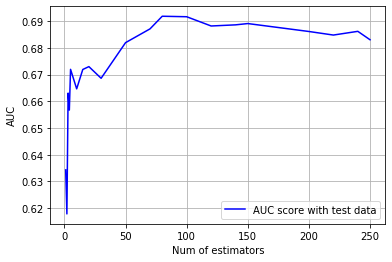

In [24]:
plt.plot(estimators_list, auc_score, 'b', label='AUC score with test data')
plt.grid(b=True)
plt.xlabel('Num of estimators')
plt.ylabel('AUC')
plt.legend()
plt.show()

The performance is better for the classifier between 80 - 100 estimators. 

   depth  train_accuracy  test_accuracy
0      1        0.734911       0.734209
1      2        0.734911       0.734209
2      3        0.765680       0.768985
3      4        0.784379       0.790632
4      5        0.795976       0.803052
5     10        0.859172       0.800568
6     15        0.947456       0.782115
7     20        0.958107       0.771824
8     50        0.957633       0.768985
9    100        0.957633       0.768985


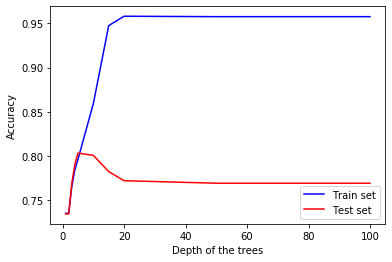

In [25]:
#hypertuning depth of the rnd forest classifier
# Depth effects the complexity of each tree. In order to balance bias vs trade-off compare with different depths.

from warnings import simplefilter
simplefilter(action = 'ignore', category = FutureWarning)

depth_list = [1,2,3,4,5,10,15,20,50,100]
test_results = []
train_results = []

for depth in depth_list:
    model2 = RandomForestClassifier(max_depth=depth, random_state= 42)
    model2.fit(X_train,y_train)
    train_results.append(model2.score(X_train, y_train))
    test_results.append(model2.score(X_test, y_test))
    
print(DataFrame({'depth':depth_list, 'train_accuracy':train_results, 'test_accuracy':test_results}))    

plt.plot(depth_list, train_results, 'b', label='Train set')
plt.plot(depth_list, test_results, 'r', label = 'Test set')
plt.xlabel('Depth of the trees')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

At a depth of 5 levels test accuracy is max at 80.3% while training accuracy is only 79.5% . 
However at a depth of 10 levels test accuracy is significantly changed but training accuracy improved to 86%.

We can perform a grid search between 5 - 10 levels along with other hyper tuned parameters. 

  feat size  train_accuracy  test_accuracy
0      sqrt        0.957633       0.768985
1      log2        0.957633       0.768985
2         1        0.957396       0.764727
3       0.7        0.958580       0.756565
4       0.5        0.958343       0.770759
5       0.3        0.959763       0.772889
6       0.1        0.957160       0.761533


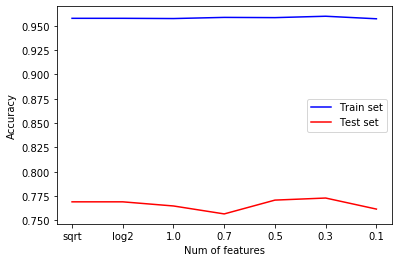

In [30]:
#Max features indicates the no . of features to consider for each split.
#More features indicates more levels of split to have a better entropy. 

max_features_list = ['sqrt', 'log2', 1.0, 0.7, 0.5, 0.3, 0.1]

test_results = []
train_results = []

for feat_size in max_features_list:
    model2 = RandomForestClassifier(max_features = feat_size, random_state= 42)
    model2.fit(X_train,y_train)
    train_results.append(model2.score(X_train, y_train))
    test_results.append(model2.score(X_test, y_test))
    
print(DataFrame({'feat size':max_features_list, 'train_accuracy':train_results, 'test_accuracy':test_results})) 

plt.plot(max_features_list, train_results, 'b', label='Train set')
plt.plot(max_features_list, test_results, 'r', label = 'Test set')
plt.xlabel('Num of features')
plt.ylabel('Accuracy')
plt.legend()
plt.show()    

With 0.3% features the accuracy if better. That is between 6 - 7 features. (0.3 * 21)

In [38]:
#lets try gridsearch with these values 

from sklearn.model_selection import GridSearchCV
from warnings import simplefilter

simplefilter(action='ignore', category = FutureWarning)

parameters = {'n_estimators':[80,100], 'max_depth':[5,7,10], 'max_features':[6,7]}

#defining the grid classifier estimator
rnd_forest = RandomForestClassifier()
rnd_forest_GridCV = GridSearchCV(rnd_forest, parameters, scoring=['accuracy', 'roc_auc'], refit = 'accuracy', cv = 5 )

#fitting the data on the model estimator
rnd_forest_GridCV.fit(X,Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [39]:
rnd_forest_GridCV.best_score_

0.7996592361209712

In [40]:
rnd_forest_GridCV.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

test score 0.804
training score 0.819
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'Accuracy': 0.804, 'Balanced acc': 0.708, 'sensitivity': 0.507, 'specificity': 0.908, 'auc': 0.84}


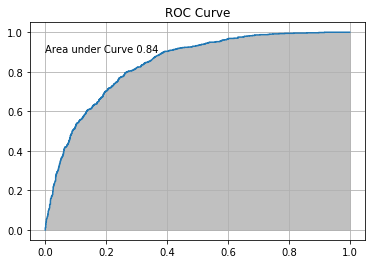

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
model_CVsplit_metrics(X,Y,rnd_forest_GridCV.best_estimator_)

Using the best random forest classifier, acheived me an 80.4% accuracy as compared to logistic regression (79.7%) but the performance of both the models (auc score) is same. 

Although Random forest gives better variance with further information in Data like amount of data used with phone service, bandwidth subscriptions with internet service etc a Random forest model can be leverage better against the complexity.

With the current data Logistic regression can be considered to make for simple and understandable model. 